# Application of Machine Learning on Air Pollution Forecasting
## Problem Background

Air pollution is contamination of the indoor or outdoor environment by any chemical, physical or biological agent that modifies the natural characteristics of the atmosphere.
According to the World Health Organisation ,more than 7 millions of people dead from air pollution per year.

The specific disease outcomes most strongly linked with exposure to air pollution include stroke, ischaemic heart disease, chronic obstructive pulmonary disease, lung cancer, pneumonia, and cataract (household air pollution only).  

There is suggestive evidence also linking air pollution exposure with increased risk for adverse pregnancy outcomes (i.e. low-birth weight, small for gestational age), other cancers, diabetes, cognitive impairment and neurological diseases. 

Moreover, air pollution also caused a large impact to the environment.Air pollution can accelerate the presence of greenhouse effect leading to more extreme weather effect and climate.

However,reducing air pollution is a long term effort and requires the cooperations of many countries. In order to mitigrate the issue, countries need to set a target every few years to keep track whether they are on the right path. Therefore in this situation, forecasting could be use to predict the future trend. The obtained result can then be used to carried out some caclulation and be set ad the target for the country.

In this experiment,we will attempt to use machine learning and evaluate a forecasting model that has the highest performance in predicting the pollution gases over a interval.


## Problem Statement
How can we make use of machine learning to predict pollution gases over time?

## Install Dependencies

In [654]:
!pip install numpy matplotlib pandas seaborn pmdarima scikit-learn==1.0.2 yellowbrick phik statsmodels pyampute xgboost imblearn missingno tqdm mlxtend category-encoders

## Import Libraries

In [655]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models


# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion

In [656]:
df=pd.read_csv('train.csv',usecols=[0,1,2,3,4], na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df

,T,RH,Gas,Value
Date,,,,
2016-03-15,12.02083,54.88333,CO,1053.20000
2016-03-16,9.83333,64.06979,CO,995.25000
2016-03-17,11.29271,51.10729,CO,1025.25000
2016-03-18,12.86632,51.53090,CO,1064.44444
2016-03-19,16.01667,48.84375,CO,1088.74167
...,...,...,...,...
2017-02-01,5.26771,39.61493,O3,553.18056
2017-02-02,-55.51597,-24.01042,O3,343.50000
2017-02-03,-14.27292,28.56354,O3,334.45833


In [657]:
data=pd.concat([pd.pivot(df, values="Value", columns="Gas"),df[["T", "RH"]].groupby(df.index).mean()],axis=1)
data

,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.20000,729.80000,933.80000,876.83333,12.02083,54.88333
2016-03-16,995.25000,681.44167,1021.75000,708.02500,9.83333,64.06979
2016-03-17,1025.25000,806.58333,881.37500,867.37500,11.29271,51.10729
2016-03-18,1064.44444,794.25833,794.52778,996.62500,12.86632,51.53090
2016-03-19,1088.74167,755.08333,800.88333,987.34167,16.01667,48.84375
...,...,...,...,...,...,...
2017-02-01,729.42222,562.65000,797.64722,553.18056,5.26771,39.61493
2017-02-02,474.29167,347.48056,508.18056,343.50000,-55.51597,-24.01042
2017-02-03,615.70000,414.47500,819.73333,334.45833,-14.27292,28.56354


## Data Exploration

In [658]:
max(data.index)

Timestamp('2017-02-05 00:00:00')

In [659]:
(data.index == data.asfreq("D").index).all()

True

### Data Structure

In [660]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      328 non-null    float64
 1   HC      328 non-null    float64
 2   NO2     328 non-null    float64
 3   O3      328 non-null    float64
 4   T       322 non-null    float64
 5   RH      322 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


### Descriptive Statistic

In [661]:
data.describe()

,CO,HC,NO2,O3,T,RH
count,328.00000,328.00000,328.00000,328.00000,322.00000,322.00000
mean,840.58348,729.58897,650.08797,780.61493,15.57842,44.34343
std,204.83152,190.47281,193.65823,261.84601,23.41286,28.48708
min,-160.00000,-160.00000,-160.00000,-160.00000,-191.16458,-188.83958
25%,779.19167,662.79583,566.09583,639.85000,12.62708,37.10104
50%,864.14167,753.68194,659.32500,794.89306,18.99375,46.45208
75%,946.43125,847.71250,754.35139,944.60833,25.71415,58.02839
max,1210.56667,1084.08333,1342.95000,1436.23333,32.99792,81.10417


### Invalid Data

In [662]:
print(str(len(data[(data < 0.00).any(axis=1)])) + " rows of invalid data found")
data[(data < 0.00).any(axis=1)]

22 rows of invalid data found


,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-04-06,850.99167,687.24722,596.38611,789.05278,-11.42604,19.74201
2016-04-14,-114.13333,-122.76667,-124.46667,-114.95833,-191.16458,-188.83958
2016-05-30,598.22500,569.85000,623.55000,557.07500,-23.92083,-24.78646
2016-05-31,489.02778,530.96111,480.75000,514.87778,-57.95174,-61.50069
2016-06-24,385.40278,326.96389,362.97222,305.70556,-68.06979,-58.29687
2016-06-25,-160.00000,-160.00000,-160.00000,-160.00000,NaN,NaN
2016-06-26,606.99167,630.99167,560.56667,519.94167,-12.14896,-5.41667
2016-08-14,652.89444,566.80556,486.65833,590.86111,-9.85243,9.18611
2016-08-31,48.86667,14.84167,82.01667,-0.97500,-144.07292,-138.67292


In [663]:
temp=data.iloc[:, [0,1,2,3,5]].copy()
temp[data.iloc[:, [0,1,2,3,5]]<0]=np.nan
data.iloc[:, [0,1,2,3,5]]=temp

data['T'][data['T'] < -60] = np.nan
data

,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.20000,729.80000,933.80000,876.83333,12.02083,54.88333
2016-03-16,995.25000,681.44167,1021.75000,708.02500,9.83333,64.06979
2016-03-17,1025.25000,806.58333,881.37500,867.37500,11.29271,51.10729
2016-03-18,1064.44444,794.25833,794.52778,996.62500,12.86632,51.53090
2016-03-19,1088.74167,755.08333,800.88333,987.34167,16.01667,48.84375
...,...,...,...,...,...,...
2017-02-01,729.42222,562.65000,797.64722,553.18056,5.26771,39.61493
2017-02-02,474.29167,347.48056,508.18056,343.50000,-55.51597,NaN
2017-02-03,615.70000,414.47500,819.73333,334.45833,-14.27292,28.56354


### Missing Data

In [665]:
pd.DataFrame(data.isna().sum().sort_values(ascending=False),columns=['Number of missing data'])

,Number of missing data
RH,16
T,11
HC,8
NO2,8
O3,8
CO,7


In [666]:
data[data.isnull().any(axis=1)]

,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-04-14,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-30,598.22500,569.85000,623.55000,557.07500,-23.92083,NaN
2016-05-31,489.02778,530.96111,480.75000,514.87778,-57.95174,NaN
2016-06-24,385.40278,326.96389,362.97222,305.70556,NaN,NaN
2016-06-25,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-26,606.99167,630.99167,560.56667,519.94167,-12.14896,NaN
2016-08-31,48.86667,14.84167,82.01667,NaN,NaN,NaN
2016-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-13,180.16667,182.55000,92.99167,228.00833,NaN,NaN


<AxesSubplot:title={'center':'Number of missing value in features'}>

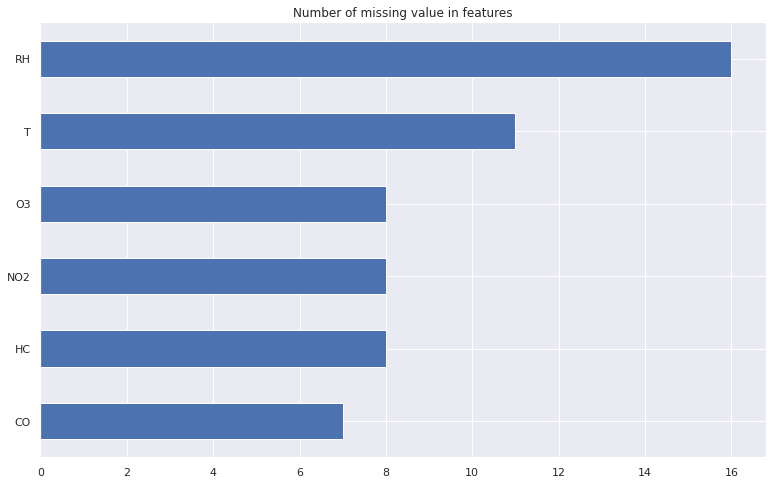

In [667]:
data.isna().sum().sort_values().plot.barh(title='Number of missing value in features')

<AxesSubplot:>

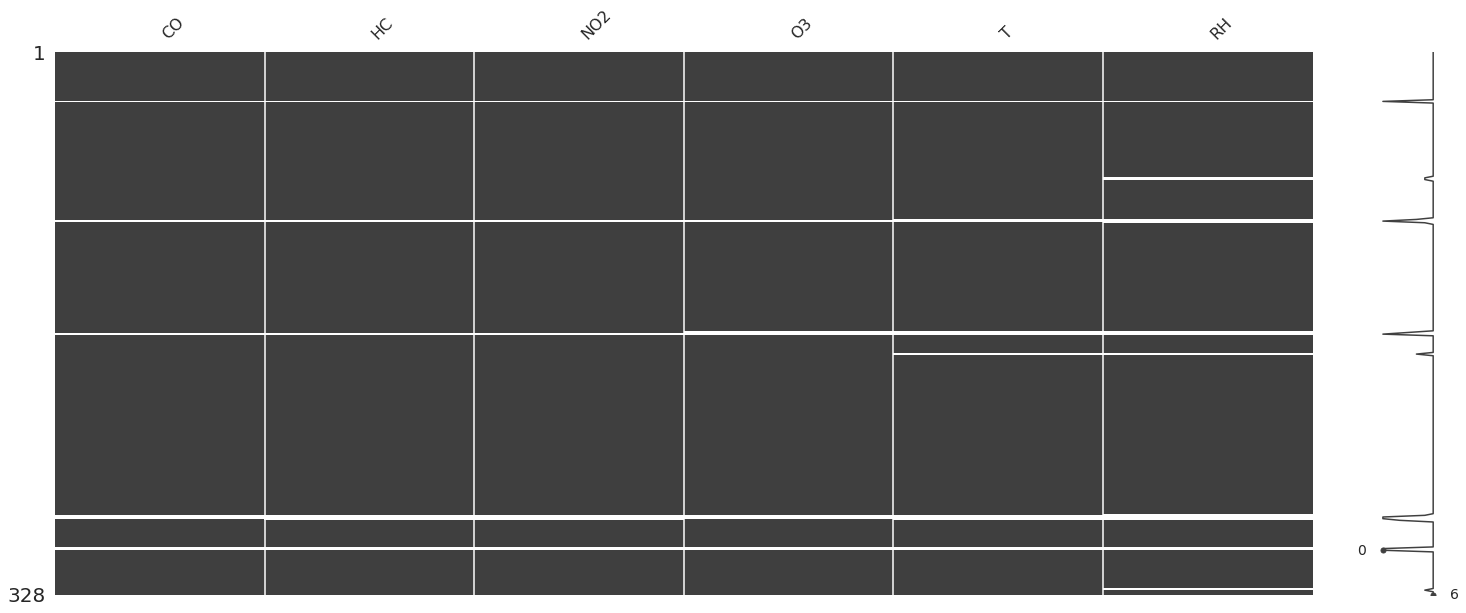

In [668]:
import missingno as msno
msno.matrix(data)

### Outliers

In [669]:
span=7
def outlier_detection(target=None,windows=7,name='My Plot',ax=plt):
    mean = target.ewm(windows).mean()
    std = target.ewm(windows).std()
    std[0] = 0 
    nostd=1.9


    is_outlier = (target > (mean + nostd*std)) | (target < (mean - nostd*std))
    


    ax.plot(target, c = 'b', label = 'Actual Values')
    ax.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
    ax.plot((mean + nostd*std), 'k--', label = 'Prediction Bounds')
    ax.plot((mean - nostd*std), 'k--')
    ax.set_title(name)
    ax.scatter(target[is_outlier].index, target[is_outlier], c = 'r', marker = 'o', s = 120, label = 'Outliers')
    ax.legend()
    return is_outlier

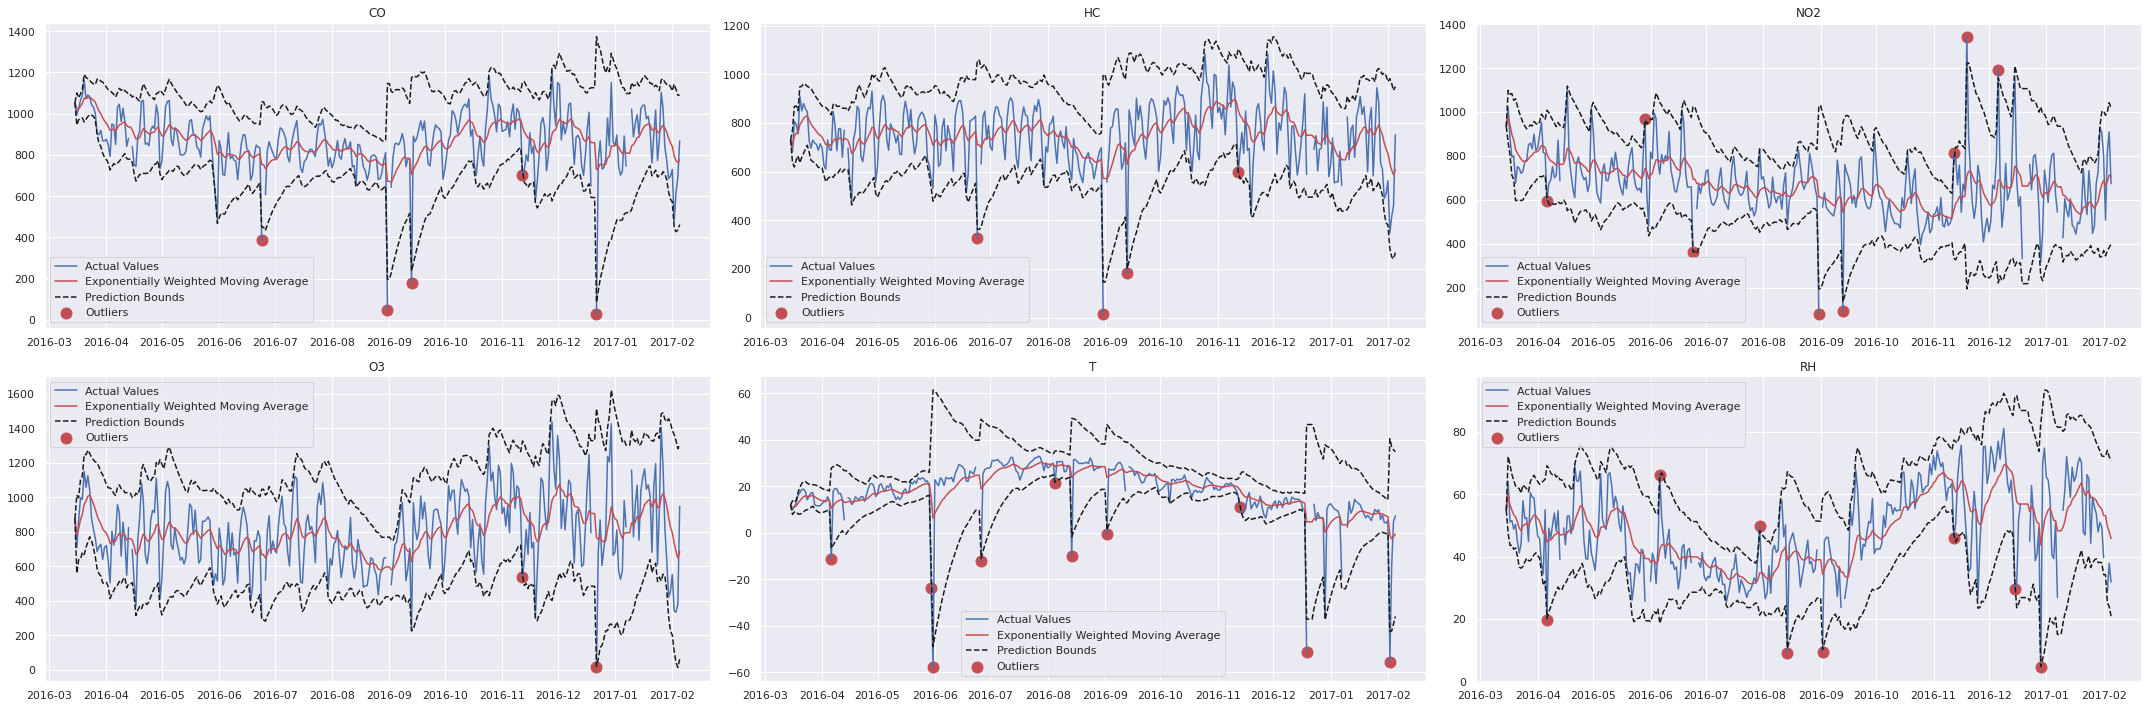

In [670]:
fig, ax = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)
ax = ax.flatten()
for col,name in enumerate(data.columns):
    outlier_detection(data[name],7,name,ax[col])

### Distribution

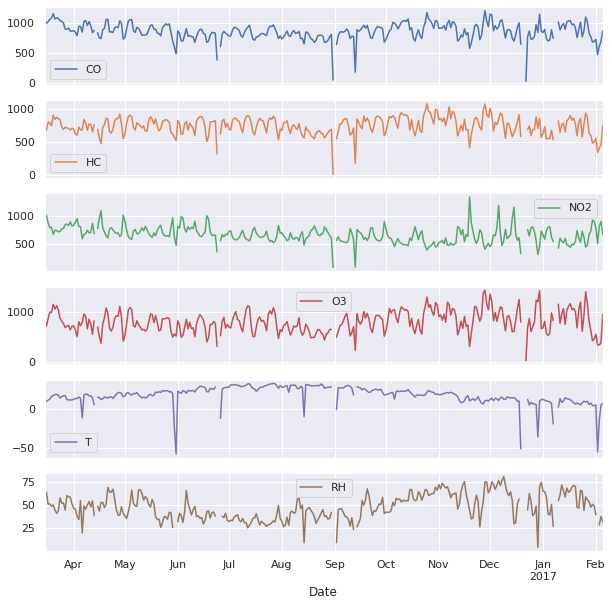

In [671]:
data.plot(subplots=True, figsize=(10, 10))
plt.show()

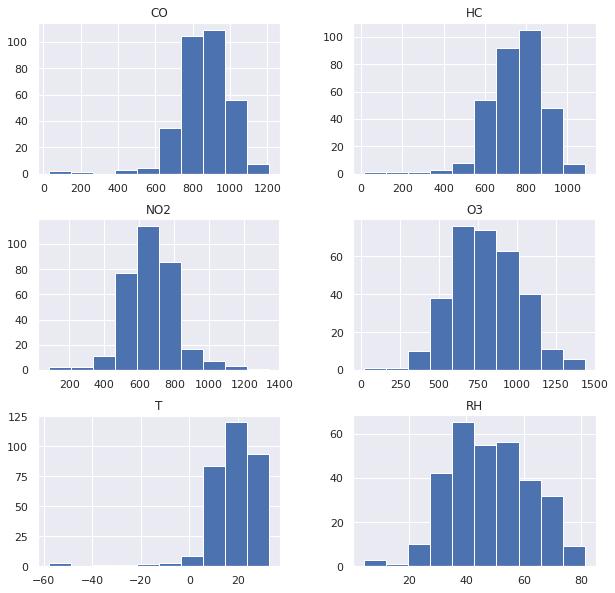

In [672]:
data.hist(figsize=((10,10)))
plt.show()

### Managing Outliers

In [673]:
# nostd=1.9
# def outlierslocation(target):
#     mean = target.ewm(7).mean()
#     std = target.ewm(7).std()
#     std[0] = 0 

#     is_outlier = (target > (mean + nostd*std)) | (target < (mean - nostd*std))
#     return is_outlier

In [674]:
# for feauture in data.columns:
#     data[feauture][outlierslocation(data[feauture])]=np.nan
cdata=data.interpolate(method='time', limit_direction='forward')

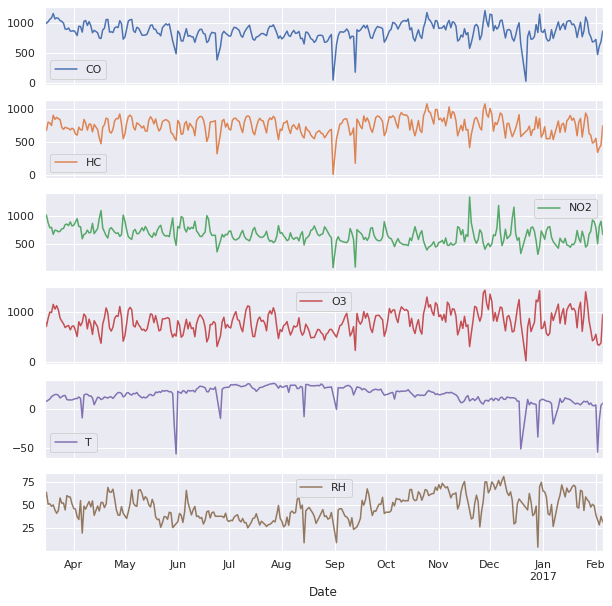

In [675]:
cdata.plot(subplots=True, figsize=(10, 10))
plt.show()

### Seasonal and Trend decomposition using Loess

In [676]:
def strength(stl=None,element='Unknown element',record=pd.DataFrame({'Name':[],'Seasonality':[],'Trend':[]})):
    trend=max(0,1-(stl.resid.var())/(stl.trend+stl.resid).var())
    season=max(0,1-(stl.resid.var())/(stl.seasonal+stl.resid).var())
    print('The trend and seasonality have a strength of '+str(trend)+', '+str(season)+' respectively.')
    record=pd.concat([record,pd.DataFrame({'Name':[element],'Seasonality':[season],'Trend':[trend]})],ignore_index=True)
    return pd.DataFrame({'Name':[element],'Seasonality':[season],'Trend':[trend]}),record
    

In [677]:
from statsmodels.tsa.seasonal import STL
def STLDecomposition(target,):
    stl = STL(target,robust=True)
    res = stl.fit()
    fig = res.plot()
    return res

The trend and seasonality have a strength of 0.3880788279783952, 0.07354856663208564 respectively.


,Name,Seasonality,Trend
0,CO,0.07355,0.38808


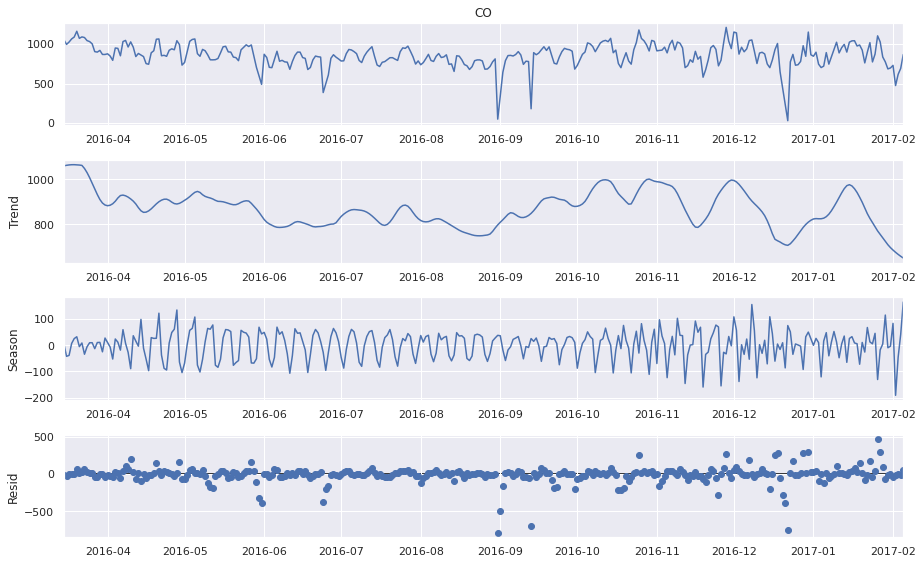

In [678]:
current,record=strength(STLDecomposition(cdata.CO),'CO')
current


The trend and seasonality have a strength of 0.4333479174617805, 0 respectively.


,Name,Seasonality,Trend
0,Temperature,0,0.43335


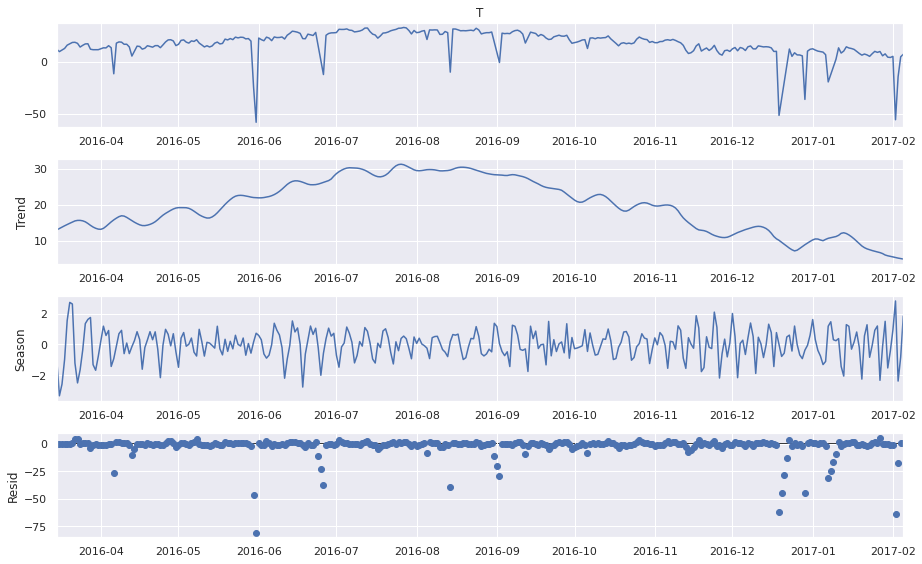

In [679]:
current,record=strength(STLDecomposition(cdata['T']),'Temperature',record)
current


The trend and seasonality have a strength of 0.3127560573490342, 0.13105866459856452 respectively.


,Name,Seasonality,Trend
0,NO2,0.13106,0.31276


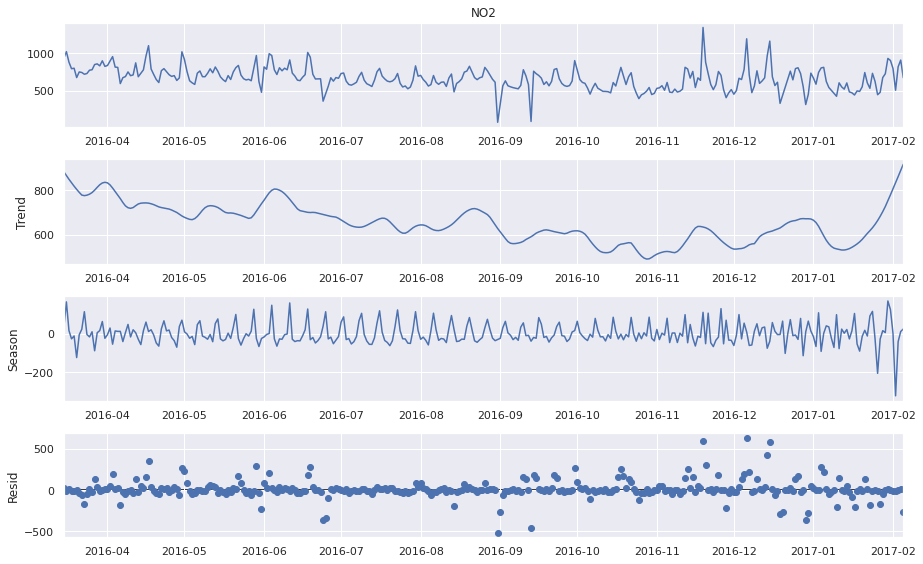

In [680]:
current,record=strength(STLDecomposition(cdata['NO2']),'NO2',record)
current



The trend and seasonality have a strength of 0.6222687636606921, 0.06427123931738543 respectively.


,Name,Seasonality,Trend
0,Relative Humidity,0.06427,0.62227


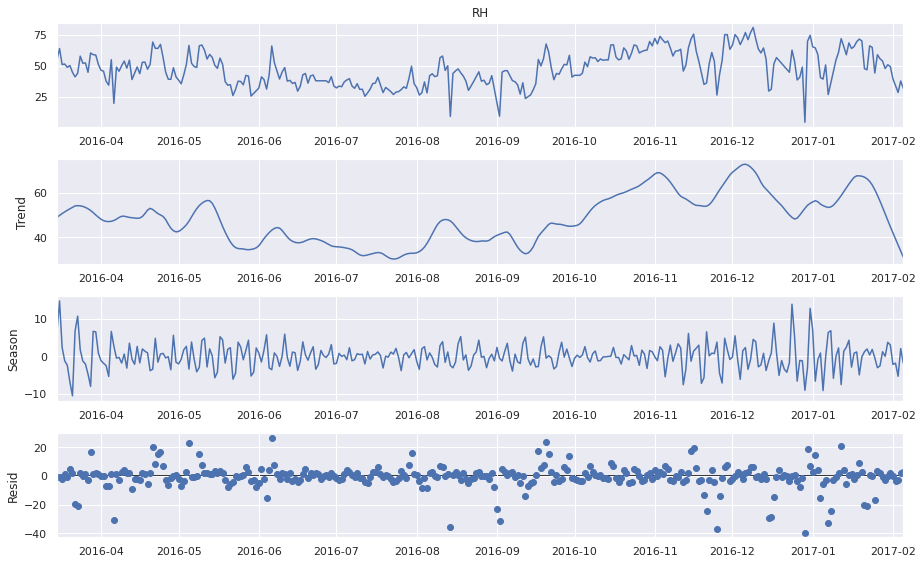

In [681]:
current,record=strength(STLDecomposition(cdata['RH']),'Relative Humidity',record)
current


The trend and seasonality have a strength of 0.36937198660672677, 0.22113505400581035 respectively.


,Name,Seasonality,Trend
0,O3,0.22114,0.36937


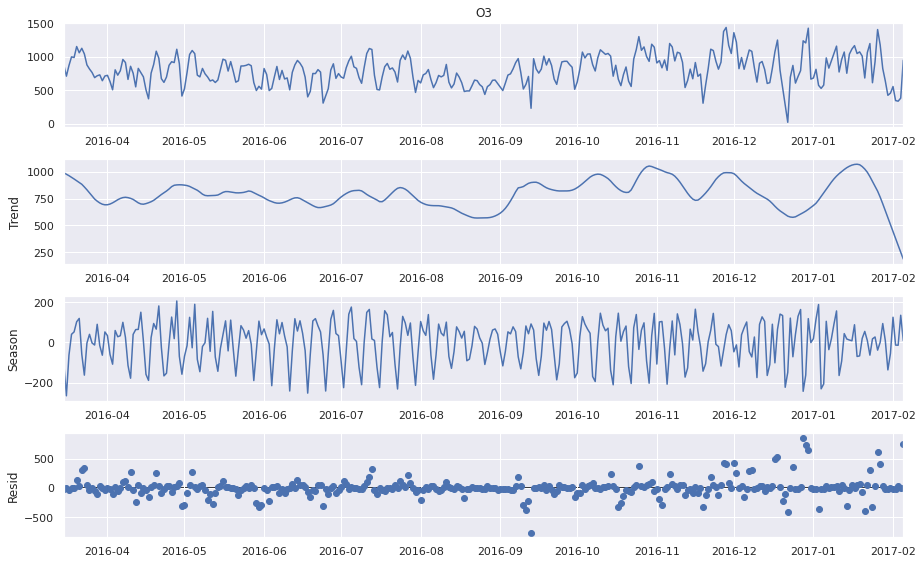

In [682]:

current,record=strength(STLDecomposition(cdata['O3']),'O3',record)
current



The trend and seasonality have a strength of 0.31213759989783296, 0.23913992689751706 respectively.


,Name,Seasonality,Trend
0,HC,0.23914,0.31214


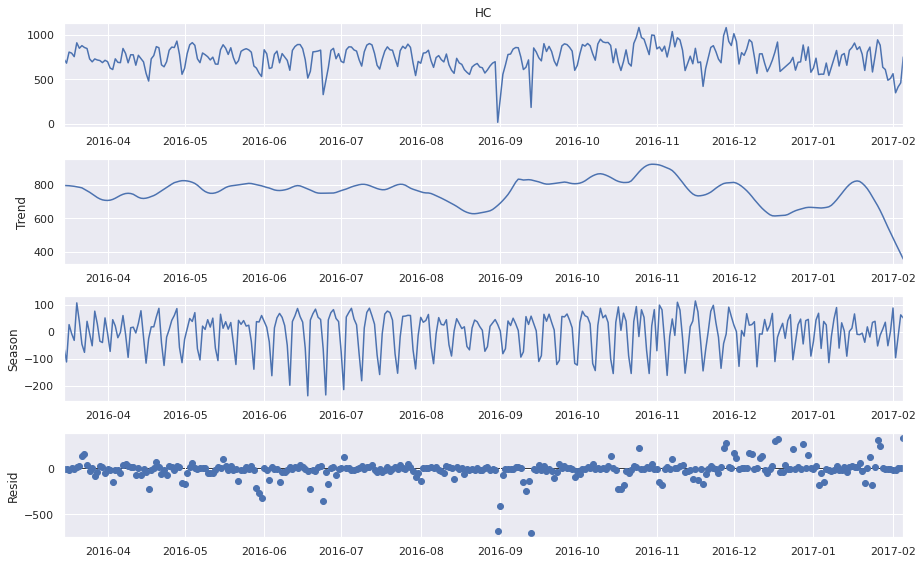

In [683]:

current,record=strength(STLDecomposition(cdata['HC']),'HC',record)
current



### Measuring Trend and Seasonality

In [684]:
record

,Name,Seasonality,Trend
0,CO,0.07355,0.38808
1,Temperature,0.00000,0.43335
2,NO2,0.13106,0.31276
3,Relative Humidity,0.06427,0.62227
4,O3,0.22114,0.36937
5,HC,0.23914,0.31214


## Modelling and Evaluation

In [685]:
import warnings
warnings.filterwarnings("ignore")

In [686]:
def EvaluationCV(data,columns,algorithm=ExponentialSmoothing,name='Unknown',n=5,ari=None,parameter=dict({
    'CO':dict({
    }),
    'NO2':dict({
    }),
    'O3':dict({
    }),
    'HC':dict({
    })
}),exog=None,record=pd.DataFrame({"Component":[],'Train RMSE':[],'Test RMSE':[]})):
    learningcurve=[0,0,0,0]
    learningcurve[0]=[]
    learningcurve[1]=[]
    learningcurve[2]=[]
    learningcurve[3]=[]
    current=pd.DataFrame({"Component":[],'Train RMSE':[],'Test RMSE':[]})
    lasttestrmse=[]
    lasttrainrmse=[]
    if ari==False:
        fig, ax = plt.subplots(2, 2, figsize=(13, 13))
        ax = ax.flatten()
        axcount=0

    for ind,feature in enumerate(columns):
        testrmse=[]
        trainrmse=[]
        instances=[]
        count=0
        for train_index, test_index in TimeSeriesSplit(n_splits=n).split(data[feature]):
            count=count+1
            if exog:

                model=algorithm(data[feature][train_index],**(parameter[feature]),exog=data[exog].iloc[train_index,0:2]).fit()
                y_pred=model.predict(min(data[feature][test_index].index),max(data[feature][test_index].index),exog=data[exog].iloc[test_index,0:2])
            else:
                model=algorithm(data[feature][train_index],**(parameter[feature])).fit()
                y_pred=model.predict(min(data[feature][test_index].index),max(data[feature][test_index].index))
            if count==n and ari==True:
                model.plot_diagnostics(figsize=((8,5)))
                lasttestrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
                lasttrainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
            elif count==n:
                model.resid.plot(ax=ax[axcount])
                ax[axcount].set_title('Residuel plot for '+feature)
                axcount=axcount+1
                lasttestrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
                lasttrainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
            instances.append(len(train_index))
            testrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
            trainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
        learningcurve[ind].append(instances)
        learningcurve[ind].append(trainrmse)
        learningcurve[ind].append(testrmse)
        current=pd.concat([record,current,pd.DataFrame({"Component":[name+' on '+feature],'Train RMSE':[sum(trainrmse)/len(trainrmse)],'Test RMSE':[sum(testrmse)/len(testrmse)]})])
    lastprediction=pd.DataFrame({'Feature':columns,'Last Train RMSE':lasttrainrmse,'Last Test RMSE':lasttestrmse})
    return current,record,lastprediction,learningcurve


### Exponential Smoothing

In [450]:
parameter=dict({
    'CO':dict({
        'seasonal':'add',
        'seasonal_periods':7
    }),
    'NO2':dict({
          'trend':'mul',
        'seasonal':'add',
         'seasonal_periods':7
    }),
    'O3':dict({

        'seasonal':'mul',
         'seasonal_periods':7
    }),
    'HC':dict({
          'trend':'mul',
        'seasonal':'mul',
         'seasonal_periods':7
    })
})

,Feature,Last Train RMSE,Last Test RMSE
0,CO,112.92898,213.91163
1,NO2,121.42079,174.93733
2,O3,145.17430,318.57819
3,HC,104.14897,151.68338


,Component,Train RMSE,Test RMSE
0,Exponential Smoothing on CO,94.39138,159.35458
0,Exponential Smoothing on NO2,107.76984,147.22953
0,Exponential Smoothing on O3,137.93810,240.33302
0,Exponential Smoothing on HC,90.29685,151.99664


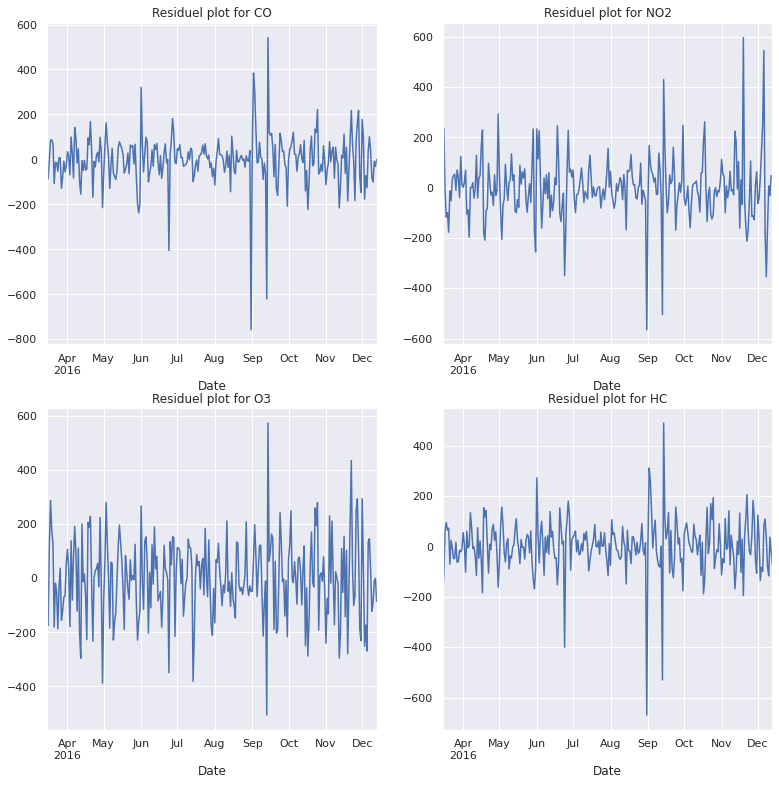

In [452]:
current,record,lastprediction,lr=EvaluationCV(cdata,['CO','NO2','O3','HC'],ExponentialSmoothing,'Exponential Smoothing',5,False,parameter)
display(lastprediction)
current

In [ ]:
current,record,lastprediction,lr=EvaluationCV(cdata,['CO','NO2','O3','HC'],ExponentialSmoothing,'Exponential Smoothing',5,False,parameter)
display(lastprediction)
current

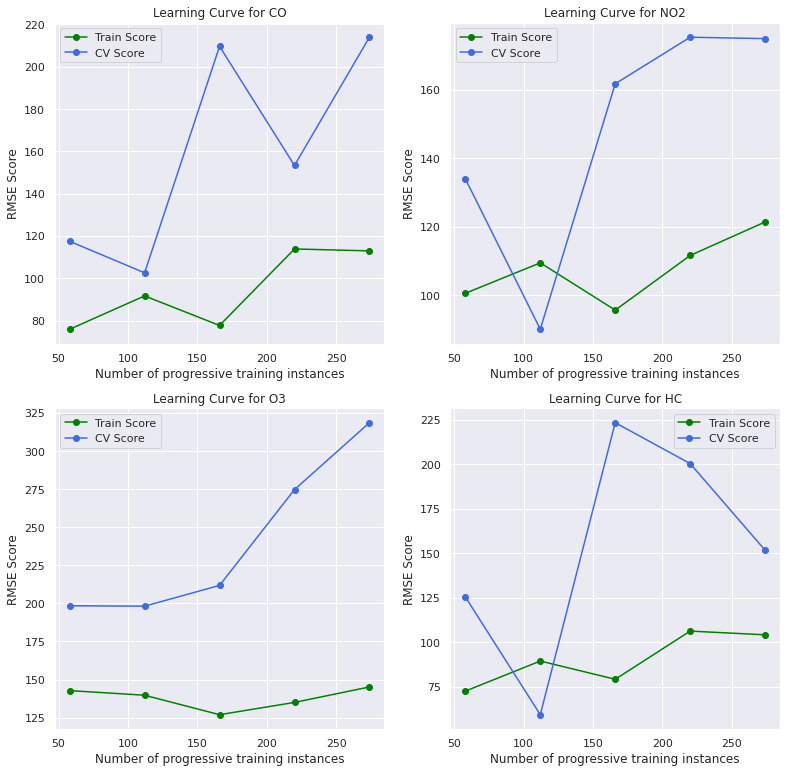

In [453]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
ax = ax.flatten()
for ind,feature in enumerate(['CO','NO2','O3','HC']):
    ax[ind].plot(lr[ind][0],lr[ind][1],label='Train Score',color='green',marker='o')
    ax[ind].plot(lr[ind][0],lr[ind][2],label='CV Score',color='royalblue',marker='o')
    ax[ind].set_title('Learning Curve for '+feature)
    ax[ind].set_xlabel('Number of progressive training instances')
    ax[ind].set_ylabel('RMSE Score')
    ax[ind].legend()

### ARIMA

#### Test for Stationary

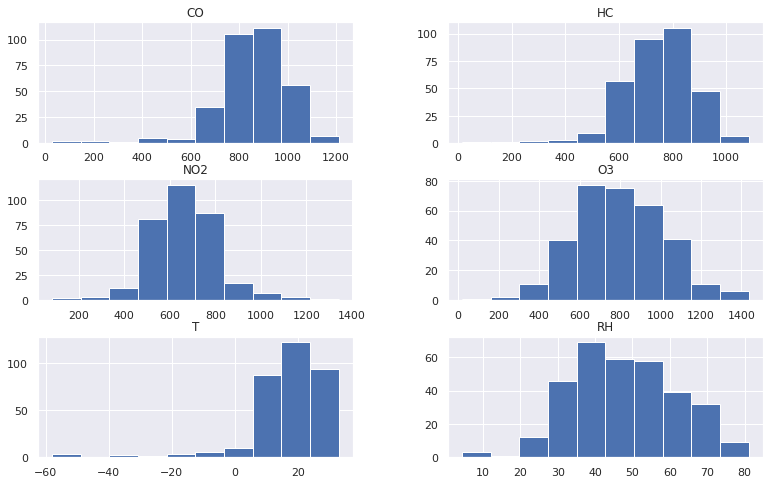

In [687]:
cdata.hist()
plt.show()

In [688]:
def adftest(df, significance_level = 0.05):
    for feature in df.columns:
        print('-----------'+feature+'-------------')
        print(f"Test for Stationarity: {significance_level}\nH0: It is non-stationary \nH1: It is stationary")
        test_statistic, pvalue, usedlag,*w, = adfuller(df[feature])
        print(f"p-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Since the p-values of "+str(pvalue)+"is <a=0.05.There is sufficient evidence to reject H0 that the data is non-stationary.")
        else:
            print("Since the p-values of "+str(pvalue)+"is >a=0.05. There is insufficient evidence to reject H0 that the data is non-stationary.")
        print('----------------------------------')

In [689]:
adftest(cdata)

-----------CO-------------
Test for Stationarity: 0.05
H0: It is non-stationary 
H1: It is stationary
p-value: 0.000
Used Lag: 1
Since the p-values of 4.898371193714017e-13is <a=0.05.There is sufficient evidence to reject H0 that the data is non-stationary.
----------------------------------
-----------HC-------------
Test for Stationarity: 0.05
H0: It is non-stationary 
H1: It is stationary
p-value: 0.032
Used Lag: 12
Since the p-values of 0.03182527644117526is <a=0.05.There is sufficient evidence to reject H0 that the data is non-stationary.
----------------------------------
-----------NO2-------------
Test for Stationarity: 0.05
H0: It is non-stationary 
H1: It is stationary
p-value: 0.000
Used Lag: 6
Since the p-values of 0.00027723969665071165is <a=0.05.There is sufficient evidence to reject H0 that the data is non-stationary.
----------------------------------
-----------O3-------------
Test for Stationarity: 0.05
H0: It is non-stationary 
H1: It is stationary
p-value: 0.000
Use

#### Selecting the Order of the ARIMA Model

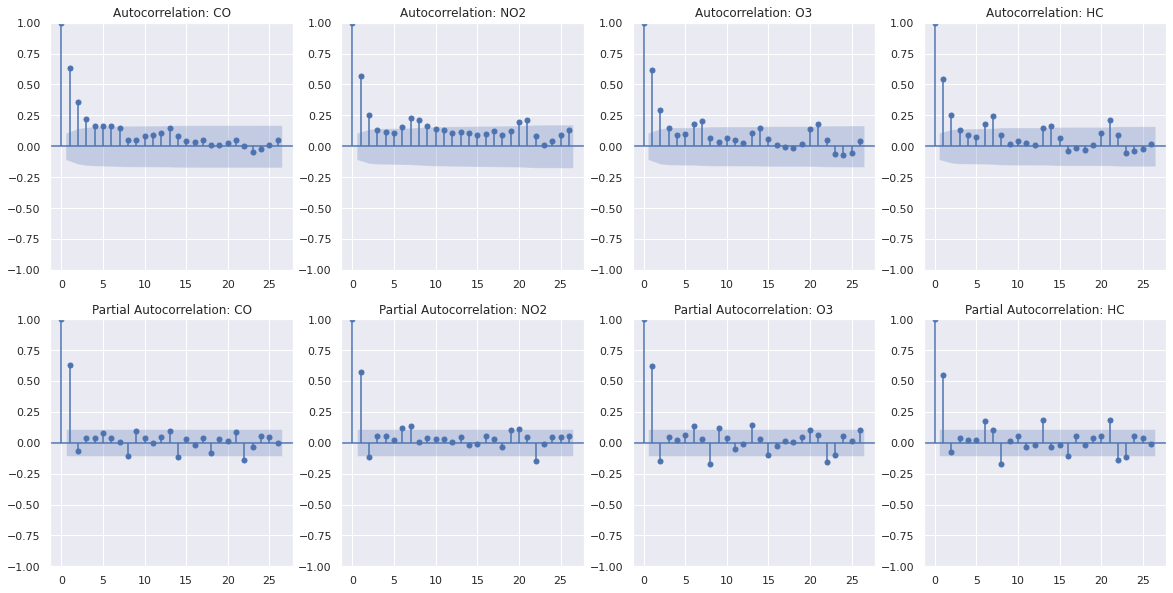

In [690]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, plot in enumerate([plot_acf, plot_pacf],0):
    for j, gas in enumerate(['CO','NO2','O3','HC'], 0):
        
        plot(cdata[gas], ax=ax[i,j])
        ax[i,j].set_title(ax[i,j].title._text + ': ' + gas)
    

In [691]:
pd.DataFrame({'Name':['CO','NO2','O3','HC'],'Order':['(1,0,2)','(1,0,3)','(1,0,2)','(1,0,2)']})

,Name,Order
0,CO,"(1,0,2)"
1,NO2,"(1,0,3)"
2,O3,"(1,0,2)"
3,HC,"(1,0,2)"


In [692]:
from pmdarima.arima import auto_arima
def arimamodel(timeseriesarray, exogenous=cdata[['T','RH']]):
    autoarima_model = auto_arima(timeseriesarray, 
                              start_p=0, # auto-regressive (AR)
                              start_q=0, # moving average
                              test="adf", # ADF Augmented Dickey-Fuller test.
                            max_d=4, max_p=4,max_q=4,stationary=True,
                                     exogenous=exogenous,max_order=None
)
    return autoarima_model



In [693]:
current=pd.DataFrame({'Name':[],'Order':[]})
for feature in ['CO','NO2','O3','HC']:
    arima_model = arimamodel(cdata[feature])
    parameter = arima_model.get_params().get('order')
    now=pd.DataFrame({'Name':[feature],'Order':[parameter]})
    current=pd.concat([current,now])
current

,Name,Order
0,CO,"(1, 0, 0)"
0,NO2,"(3, 0, 1)"
0,O3,"(1, 0, 1)"
0,HC,"(1, 0, 0)"


,Feature,Last Train RMSE,Last Test RMSE
0,CO,103.63473,170.00853
1,NO2,114.78342,150.39392
2,O3,144.41788,303.19928
3,HC,107.38849,119.67494


,Component,Train RMSE,Test RMSE
0,ARIMA on CO,90.54215,145.96239
0,ARIMA on NO2,96.78637,155.33162
0,ARIMA on O3,129.37358,247.27368
0,ARIMA on HC,91.90777,135.53044


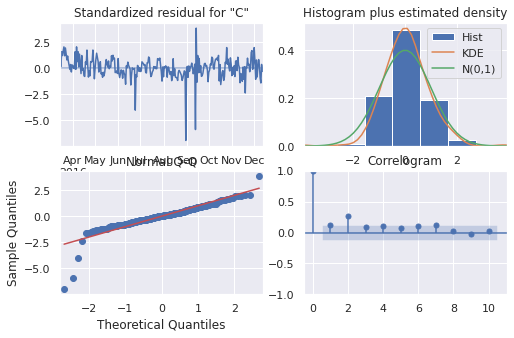

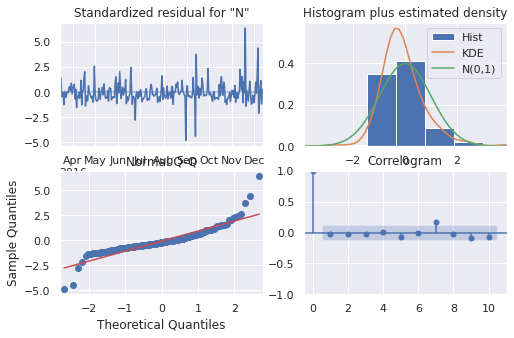

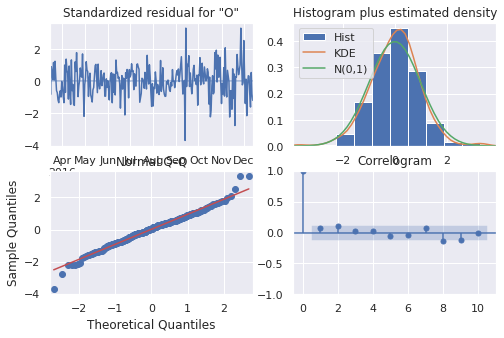

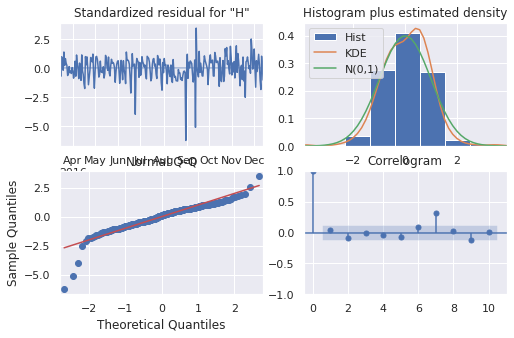

In [696]:
pd.options.display.float_format = '{:.5f}'.format
parameter=dict({
    'CO':dict({
        'order':(0, 0, 1),
    }),
    'NO2':dict({
#         'trend':'t',
        'order':(1, 0, 3),
        
    }),
    'O3':dict({
     
        'order':(4, 0, 5),

    }),
    'HC':dict({
#         'trend':'ct',
        'order':(1, 0, 0)
    })
})
current,record,lastprediction,lr=EvaluationCV(cdata,['CO','NO2','O3','HC'],ARIMA,'ARIMA',5,True,parameter,['T','RH'])
display(lastprediction)
current

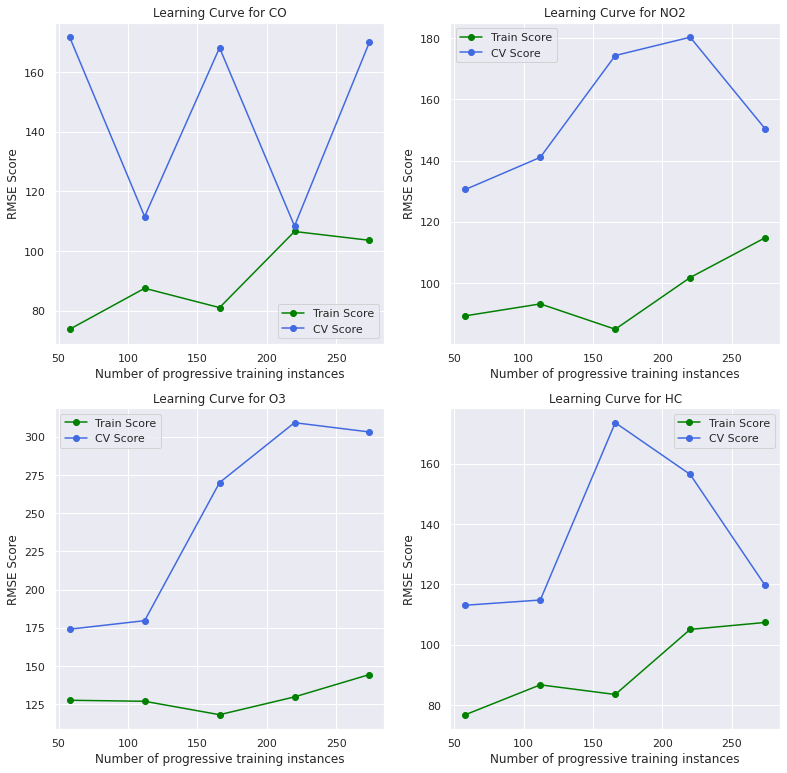

In [697]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
ax = ax.flatten()
for ind,feature in enumerate(['CO','NO2','O3','HC']):
    ax[ind].plot(lr[ind][0],lr[ind][1],label='Train Score',color='green',marker='o')
    ax[ind].plot(lr[ind][0],lr[ind][2],label='CV Score',color='royalblue',marker='o')
    ax[ind].set_title('Learning Curve for '+feature)
    ax[ind].set_xlabel('Number of progressive training instances')
    ax[ind].set_ylabel('RMSE Score')
    ax[ind].legend()

In [631]:
# def HanGridSearchCV(odata,ft,arimax=True):
#     bestresult=300
#     finalaccuracy=300
#     data=odata[ft].copy()
#     for P in np.arange(0,5):
#         for Q in np.arange(0,6):
#             order = (P,0,Q)
#             temp=[]
#             count=0
#             for train_index, test_index in TimeSeriesSplit(n_splits=5).split(data):
#                 count=count+1
#                 model=ARIMA(data[train_index],order=order,exog=odata[['T','RH']].iloc[train_index,0:2]).fit()
#                 y_pred=model.predict(min(data[test_index].index),max(data[test_index].index),exog=odata[['T','RH']].iloc[test_index,0:2])
#                 temp.append(mean_squared_error(data[test_index], y_pred, squared=False))

#             if (temp[4])<finalaccuracy:
#                 bestresult=(P,0,Q)
#                 finalaccuracy=temp[4]
#     return bestresult,finalaccuracy
# bestresult,finalaccuracy=HanGridSearchCV(cdata,'O3')
# finalaccuracy

### SARIMAX

#### Seasonal Order

In [527]:
slag = [i*7 for i in range(13)]
slag

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]

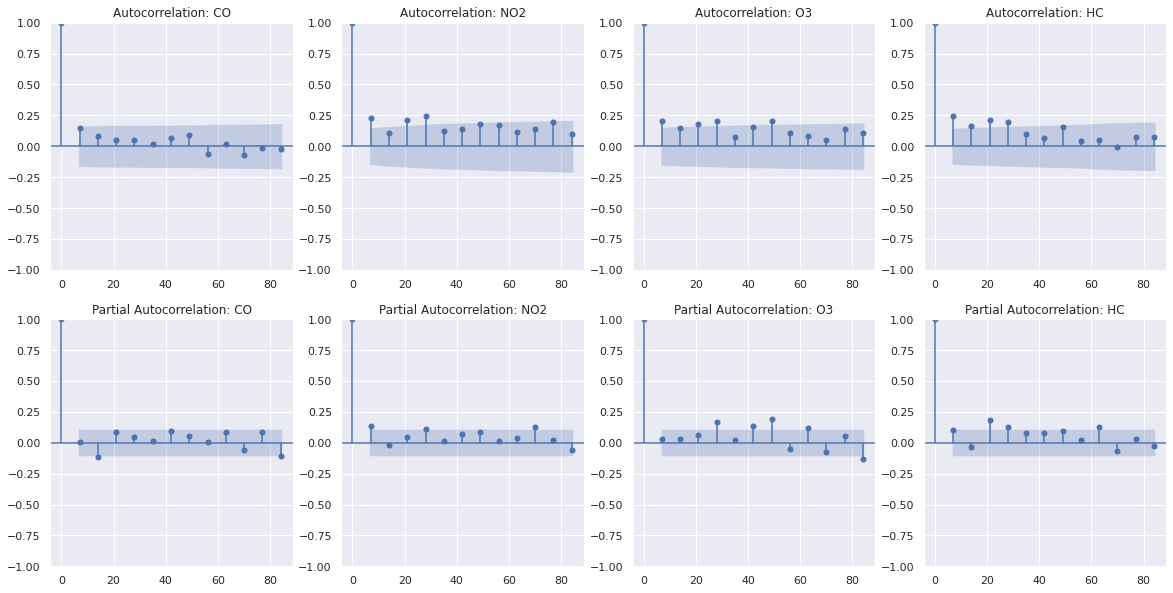

In [528]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, plot in enumerate([plot_acf, plot_pacf],0):
    for j, gas in enumerate(['CO','NO2','O3','HC'], 0):
        
        plot(cdata[gas], ax=ax[i,j], lags=slag)
        ax[i,j].set_title(ax[i,j].title._text + ': ' + gas)

In [529]:
pd.DataFrame({'Name':['CO','NO2','O3','HC'],'Seasonal Order':['(0,0,0,7)','(0,0,1,7)','(0,0,1,7)','(0,0,1,7)']})

,Name,Seasonal Order
0,CO,"(0,0,0,7)"
1,NO2,"(0,0,1,7)"
2,O3,"(0,0,1,7)"
3,HC,"(0,0,1,7)"


In [558]:
from pmdarima.arima import auto_arima
def sarimamodel(timeseriesarray, exogenous=cdata[['T','RH']]):
    autoarima_model = auto_arima(timeseriesarray, 
                              start_p=0, # auto-regressive (AR)
                              start_q=0, # moving average
                              test="adf", # ADF Augmented Dickey-Fuller test.
                            max_d=4, max_p=4,max_q=4,stationary=True,max_P=7,max_Q=7,start_P=0,start_Q=0,
                                     exogenous=exogenous,max_order=20,seasonal=True,m=7,n_jobs=-1
)
    return autoarima_model

current=pd.DataFrame({'Name':[],'Order':[]})
for feature in ['CO','NO2','O3','HC']:
    sarima_model = sarimamodel(cdata[feature])
    print( sarima_model.summary())
    parameter = sarima_model.get_params()

    now=pd.DataFrame({'Name':[feature],'Order':[str(parameter['order'])+str(parameter['seasonal_order'])]})
    current=pd.concat([current,now])
current

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2000.987
Date:                             Thu, 07 Jul 2022   AIC                           4015.975
Time:                                     12:54:38   BIC                           4042.526
Sample:                                 03-15-2016   HQIC                          4026.568
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.8621     15.878      0.810      0.418     -18.258      43.982
T              2.5258      

,Name,Order
0,CO,"(1, 0, 0)(1, 0, 1, 7)"
0,NO2,"(1, 0, 0)(1, 0, 1, 7)"
0,O3,"(2, 0, 0)(1, 0, 1, 7)"
0,HC,"(1, 0, 0)(1, 0, 1, 7)"


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41916D+00    |proj g|=  2.83882D-02

At iterate    5    f=  6.39676D+00    |proj g|=  1.10054D-01

At iterate   10    f=  6.15509D+00    |proj g|=  8.78031D-02

At iterate   15    f=  6.13727D+00    |proj g|=  3.00321D-02

At iterate   20    f=  6.07540D+00    |proj g|=  1.84115D-02

At iterate   25    f=  6.04634D+00    |proj g|=  5.35176D-02

At iterate   30    f=  5.89543D+00    |proj g|=  8.79859D-02

At iterate   35    f=  5.82688D+00    |proj g|=  2.10142D-03

At iterate   40    f=  5.79024D+00    |proj g|=  9.62825D-02

At iterate   45    f=  5.73944D+00    |proj g|=  1.68194D-02

At iterate   50    f=  5.73750D+00    |proj g|=  1.12904D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33651D+00    |proj g|=  3.20472D-02

At iterate    5    f=  6.19084D+00    |proj g|=  2.29649D-01

At iterate   10    f=  6.05665D+00    |proj g|=  5.12296D-02

At iterate   15    f=  6.01975D+00    |proj g|=  5.40338D-03

At iterate   20    f=  5.82103D+00    |proj g|=  8.62148D-02

At iterate   25    f=  5.76173D+00    |proj g|=  4.84430D-03

At iterate   30    f=  5.76151D+00    |proj g|=  6.79808D-05

At iterate   35    f=  5.76144D+00    |proj g|=  2.72063D-03

At iterate   40    f=  5.76068D+00    |proj g|=  3.69724D-03

At iterate   45    f=  5.76054D+00    |proj g|=  1.20753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36621D+00    |proj g|=  3.21515D-02

At iterate    5    f=  6.15337D+00    |proj g|=  1.83431D-01

At iterate   10    f=  6.05024D+00    |proj g|=  1.29514D-02

At iterate   15    f=  5.99158D+00    |proj g|=  1.25128D-02

At iterate   20    f=  5.92186D+00    |proj g|=  2.04228D-01

At iterate   25    f=  5.64727D+00    |proj g|=  4.75088D-02

At iterate   30    f=  5.64498D+00    |proj g|=  2.26668D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42261D+00    |proj g|=  2.75308D-02

At iterate    5    f=  6.22449D+00    |proj g|=  8.27820D-02

At iterate   10    f=  6.18754D+00    |proj g|=  1.83779D-02

At iterate   15    f=  6.14676D+00    |proj g|=  1.55006D-02

At iterate   20    f=  6.13623D+00    |proj g|=  2.95687D-02

At iterate   25    f=  6.03219D+00    |proj g|=  9.50600D-03

At iterate   30    f=  6.01985D+00    |proj g|=  1.02202D-04

At iterate   35    f=  6.01985D+00    |proj g|=  3.75060D-04


 This problem is unconstrained.



At iterate   40    f=  6.01982D+00    |proj g|=  2.35282D-03

At iterate   45    f=  6.01977D+00    |proj g|=  6.05899D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     54      1     0     0   1.483D-06   6.020D+00
  F =   6.0197694531643986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36506D+00    |proj g|=  2.97574D-02

At iterate    5    f=  6.16109D+00    |proj g|=  4.79670D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  6.02222D+00    |proj g|=  1.97255D-02

At iterate   25    f=  6.01653D+00    |proj g|=  1.12806D-03

At iterate   30    f=  6.01652D+00    |proj g|=  2.52469D-04

At iterate   35    f=  6.01641D+00    |proj g|=  3.86515D-03

At iterate   40    f=  6.01596D+00    |proj g|=  5.18131D-04

At iterate   45    f=  6.01594D+00    |proj g|=  3.48826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     55      1     0     0   8.885D-06   6.016D+00
  F =   6.0159443138702722     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  6.20222D+00    |proj g|=  2.51984D-02

At iterate   25    f=  6.16710D+00    |proj g|=  1.99478D-02

At iterate   30    f=  6.01422D+00    |proj g|=  1.42377D-01

At iterate   35    f=  5.97770D+00    |proj g|=  4.27374D-02

At iterate   40    f=  5.97460D+00    |proj g|=  1.26349D-03

At iterate   45    f=  5.97408D+00    |proj g|=  1.54533D-04

At iterate   50    f=  5.97408D+00    |proj g|=  2.29174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   2.292D-04   5.974D+00
  F =   5.9740834701914052     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  6.33472D+00    |proj g|=  3.38623D-02

At iterate   10    f=  6.20234D+00    |proj g|=  4.71496D-02

At iterate   15    f=  6.14753D+00    |proj g|=  4.52952D-02

At iterate   20    f=  6.12818D+00    |proj g|=  1.49961D-02

At iterate   25    f=  6.12230D+00    |proj g|=  5.12719D-02

At iterate   30    f=  6.02754D+00    |proj g|=  7.98670D-02

At iterate   35    f=  5.97675D+00    |proj g|=  5.06274D-02

At iterate   40    f=  5.96841D+00    |proj g|=  1.15515D-02

At iterate   45    f=  5.96825D+00    |proj g|=  6.92503D-05

At iterate   50    f=  5.96824D+00    |proj g|=  1.75376D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.22016D+00    |proj g|=  1.69047D-01

At iterate   10    f=  6.11680D+00    |proj g|=  4.02535D-02

At iterate   15    f=  6.04893D+00    |proj g|=  2.57055D-02

At iterate   20    f=  6.03839D+00    |proj g|=  7.50525D-03

At iterate   25    f=  5.94915D+00    |proj g|=  1.03274D-01

At iterate   30    f=  5.85300D+00    |proj g|=  9.30657D-03

At iterate   35    f=  5.85269D+00    |proj g|=  1.19549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     45      1     0     0   1.001D-05   5.853D+00
  F =   5.8526869281872784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  6.36255D+00    |proj g|=  9.40341D-02

At iterate   15    f=  6.20409D+00    |proj g|=  1.57528D-02

At iterate   20    f=  6.17919D+00    |proj g|=  4.33797D-02

At iterate   25    f=  6.15779D+00    |proj g|=  8.44791D-03

At iterate   30    f=  6.15409D+00    |proj g|=  3.12080D-02

At iterate   35    f=  6.09452D+00    |proj g|=  4.86695D-02

At iterate   40    f=  6.03449D+00    |proj g|=  3.45709D-02

At iterate   45    f=  6.03286D+00    |proj g|=  1.22778D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     55      1     0     0   2.232D-05   6.033D+00
  F =   6.03286341135

 This problem is unconstrained.



At iterate    5    f=  6.35880D+00    |proj g|=  1.99569D-01

At iterate   10    f=  6.26274D+00    |proj g|=  9.61913D-03

At iterate   15    f=  6.26061D+00    |proj g|=  1.30085D-02

At iterate   20    f=  6.22165D+00    |proj g|=  3.52677D-02

At iterate   25    f=  6.18639D+00    |proj g|=  9.08049D-03

At iterate   30    f=  6.15708D+00    |proj g|=  4.50164D-02

At iterate   35    f=  6.15491D+00    |proj g|=  9.65672D-05

At iterate   40    f=  6.15491D+00    |proj g|=  3.36144D-04

At iterate   45    f=  6.15490D+00    |proj g|=  8.94137D-04

At iterate   50    f=  6.15482D+00    |proj g|=  4.31509D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  6.63756D+00    |proj g|=  5.74656D-04

At iterate   30    f=  6.63751D+00    |proj g|=  4.04125D-03

At iterate   35    f=  6.63515D+00    |proj g|=  2.12174D-02

At iterate   40    f=  6.63417D+00    |proj g|=  3.93050D-04

At iterate   45    f=  6.63416D+00    |proj g|=  1.85041D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     52      1     0     0   5.386D-06   6.634D+00
  F =   6.6341576805372195     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   15    f=  6.48297D+00    |proj g|=  4.59896D-02

At iterate   20    f=  6.42748D+00    |proj g|=  3.53420D-02

At iterate   25    f=  6.40307D+00    |proj g|=  1.30997D-02

At iterate   30    f=  6.39934D+00    |proj g|=  2.95115D-02

At iterate   35    f=  6.34077D+00    |proj g|=  2.44203D-02

At iterate   40    f=  6.33452D+00    |proj g|=  1.84040D-03

At iterate   45    f=  6.33447D+00    |proj g|=  1.04488D-04

At iterate   50    f=  6.33446D+00    |proj g|=  3.60102D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   3.601D-03   6.334D+00
  F =   6.33445728013

 This problem is unconstrained.



At iterate   15    f=  6.42431D+00    |proj g|=  2.11350D-02

At iterate   20    f=  6.40181D+00    |proj g|=  3.76068D-02

At iterate   25    f=  6.38614D+00    |proj g|=  5.26323D-03

At iterate   30    f=  6.35442D+00    |proj g|=  2.98968D-02

At iterate   35    f=  6.29750D+00    |proj g|=  1.67749D-02

At iterate   40    f=  6.28346D+00    |proj g|=  1.22205D-03

At iterate   45    f=  6.28345D+00    |proj g|=  4.95104D-04

At iterate   50    f=  6.28330D+00    |proj g|=  9.16235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   9.162D-03   6.283D+00
  F =   6.28330114150

 This problem is unconstrained.



At iterate    5    f=  6.59899D+00    |proj g|=  6.87262D-02

At iterate   10    f=  6.55995D+00    |proj g|=  1.64591D-01

At iterate   15    f=  6.44522D+00    |proj g|=  8.38352D-03

At iterate   20    f=  6.42381D+00    |proj g|=  4.73417D-02

At iterate   25    f=  6.41587D+00    |proj g|=  3.33228D-03

At iterate   30    f=  6.40215D+00    |proj g|=  2.62601D-02

At iterate   35    f=  6.36230D+00    |proj g|=  9.19885D-03

At iterate   40    f=  6.35861D+00    |proj g|=  6.45824D-04

At iterate   45    f=  6.35861D+00    |proj g|=  2.34901D-04

At iterate   50    f=  6.35859D+00    |proj g|=  2.63369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.59100D+00    |proj g|=  4.30462D-02

At iterate   10    f=  6.58134D+00    |proj g|=  1.27022D-01

At iterate   15    f=  6.51089D+00    |proj g|=  6.25838D-02

At iterate   20    f=  6.48882D+00    |proj g|=  7.52779D-03

At iterate   25    f=  6.47573D+00    |proj g|=  1.67635D-02

At iterate   30    f=  6.46868D+00    |proj g|=  1.12735D-02

At iterate   35    f=  6.45905D+00    |proj g|=  4.17100D-03

At iterate   40    f=  6.44704D+00    |proj g|=  2.98833D-02

At iterate   45    f=  6.44459D+00    |proj g|=  4.65302D-04

At iterate   50    f=  6.44459D+00    |proj g|=  1.24726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  6.09654D+00    |proj g|=  7.67347D-02

At iterate   30    f=  6.04119D+00    |proj g|=  4.11674D-02

At iterate   35    f=  6.00359D+00    |proj g|=  6.39580D-02

At iterate   40    f=  5.83552D+00    |proj g|=  4.93939D-02

At iterate   45    f=  5.74187D+00    |proj g|=  1.12360D-02

At iterate   50    f=  5.73942D+00    |proj g|=  1.44392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.444D-03   5.739D+00
  F =   5.7394155198475421     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  6.32874D+00    |proj g|=  2.00505D-01

At iterate   15    f=  6.18785D+00    |proj g|=  3.83595D-02

At iterate   20    f=  6.10746D+00    |proj g|=  2.77884D-02

At iterate   25    f=  6.09421D+00    |proj g|=  2.61269D-02

At iterate   30    f=  6.03212D+00    |proj g|=  4.75407D-02

At iterate   35    f=  5.94187D+00    |proj g|=  3.77731D-02

At iterate   40    f=  5.82641D+00    |proj g|=  2.68319D-02

At iterate   45    f=  5.82516D+00    |proj g|=  3.90630D-05

At iterate   50    f=  5.82515D+00    |proj g|=  1.56043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62   

 This problem is unconstrained.



At iterate    5    f=  6.36091D+00    |proj g|=  5.10997D-02

At iterate   10    f=  6.14159D+00    |proj g|=  4.16985D-02

At iterate   15    f=  6.08579D+00    |proj g|=  4.15684D-02

At iterate   20    f=  6.05598D+00    |proj g|=  2.13215D-02

At iterate   25    f=  5.97356D+00    |proj g|=  1.28019D-01

At iterate   30    f=  5.74766D+00    |proj g|=  6.44172D-02

At iterate   35    f=  5.74152D+00    |proj g|=  7.70986D-04

At iterate   40    f=  5.74151D+00    |proj g|=  7.87118D-04

At iterate   45    f=  5.74132D+00    |proj g|=  2.92178D-03

At iterate   50    f=  5.74129D+00    |proj g|=  1.68699D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.24247D+00    |proj g|=  7.31078D-02

At iterate   15    f=  6.22393D+00    |proj g|=  3.69498D-02

At iterate   20    f=  6.18267D+00    |proj g|=  2.94384D-02

At iterate   25    f=  6.16370D+00    |proj g|=  1.54544D-02

At iterate   30    f=  6.15500D+00    |proj g|=  1.55260D-02

At iterate   35    f=  6.07459D+00    |proj g|=  1.10200D-02

At iterate   40    f=  6.06177D+00    |proj g|=  4.67410D-03

At iterate   45    f=  6.05947D+00    |proj g|=  4.95975D-03

At iterate   50    f=  6.05940D+00    |proj g|=  7.16400D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59   

 This problem is unconstrained.



At iterate    5    f=  6.35874D+00    |proj g|=  4.93586D-02

At iterate   10    f=  6.23591D+00    |proj g|=  8.55037D-02

At iterate   15    f=  6.18732D+00    |proj g|=  2.11904D-02

At iterate   20    f=  6.17149D+00    |proj g|=  5.87419D-03

At iterate   25    f=  6.11203D+00    |proj g|=  6.76764D-02

At iterate   30    f=  6.07787D+00    |proj g|=  5.14352D-03

At iterate   35    f=  6.07730D+00    |proj g|=  5.90461D-05

At iterate   40    f=  6.07730D+00    |proj g|=  9.09545D-04

At iterate   45    f=  6.07727D+00    |proj g|=  1.44132D-03

At iterate   50    f=  6.07719D+00    |proj g|=  1.06694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

,Feature,Last Train RMSE,Last Test RMSE
0,CO,110.37316,167.75705
1,NO2,125.70389,158.56556
2,O3,157.60992,293.32612
3,HC,110.35522,127.66627


,Component,Train RMSE,Test RMSE
0,SARIMAX on CO,118.01780,139.71191
0,SARIMAX on NO2,122.20859,144.39959
0,SARIMAX on O3,159.05513,249.57751
0,SARIMAX on HC,106.91497,139.28255


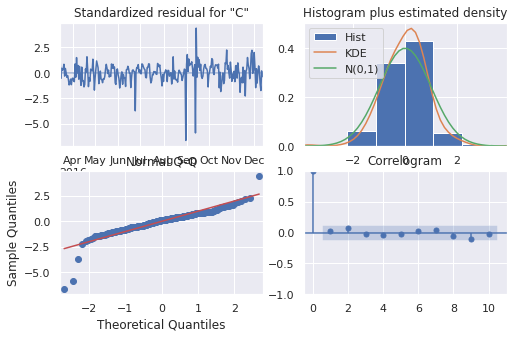

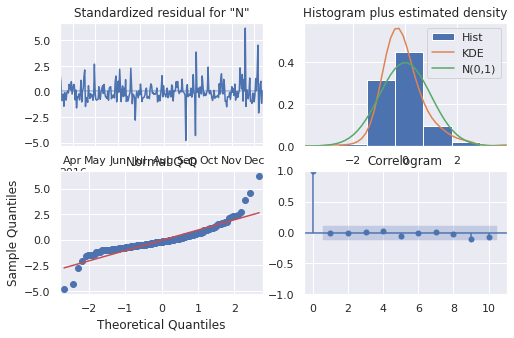

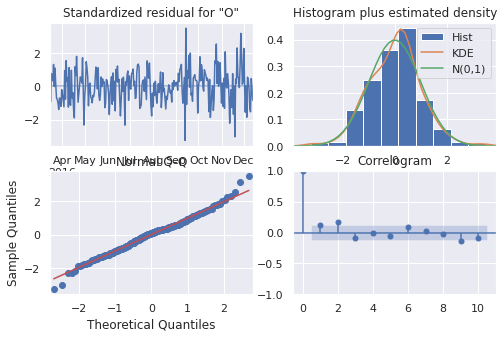

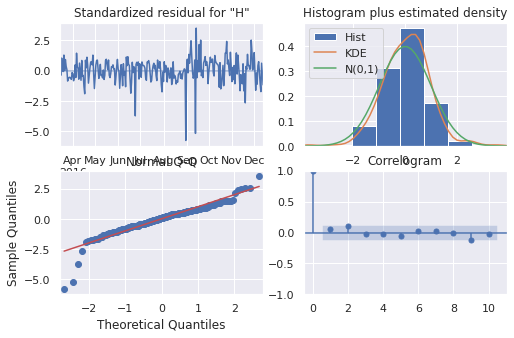

In [775]:

parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 0, 7)
    }),
    'NO2':dict({
        'order':(1, 0, 3),
        'seasonal_order':(0, 0, 1, 7)
    }),
    'O3':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 1, 7)
    }),
    'HC':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 1, 7)
    })
})




# parameter=dict({
#     'CO':dict({
#         'order':(1, 0, 0),
#         'seasonal_order':(2, 0, 0, 7)
#     }),
#     'NO2':dict({
#         'order':(1, 0, 0),
#         'seasonal_order':(3, 0, 0, 7)
#     }),
#     'O3':dict({
#         'order':(1, 0, 0),
#         'seasonal_order':(1, 0, 4, 7)
#     }),
#     'HC':dict({
#         'order':(1, 0, 2),
#         'seasonal_order':(7, 0, 7, 7)
#     })
# })







current,record,lastprediction,lr=EvaluationCV(cdata,['CO','NO2','O3','HC'],SARIMAX,'SARIMAX',5,True,parameter,['T','RH'])
display(lastprediction)
current

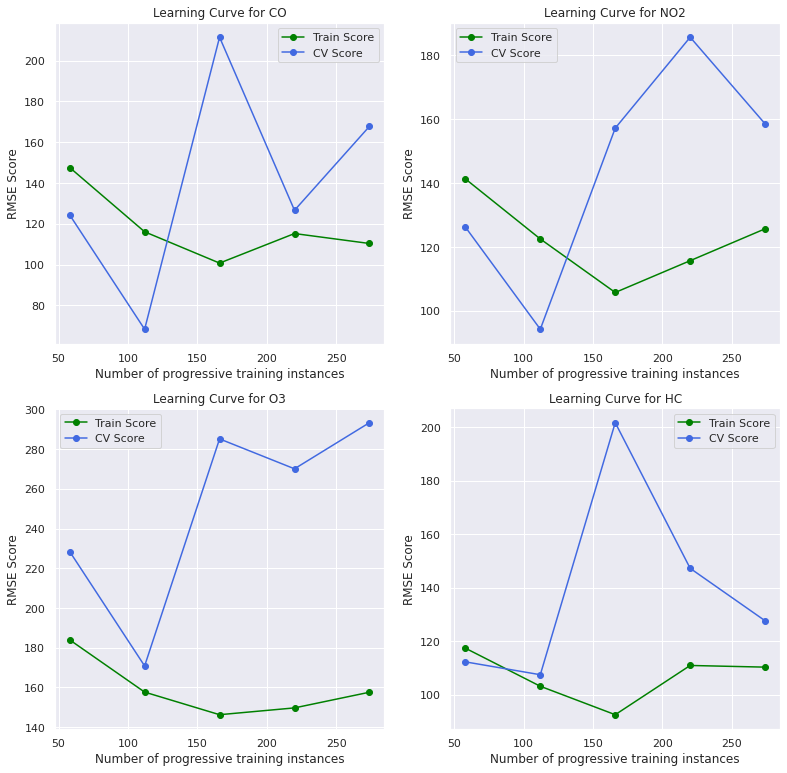

In [776]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
ax = ax.flatten()
for ind,feature in enumerate(['CO','NO2','O3','HC']):
    ax[ind].plot(lr[ind][0],lr[ind][1],label='Train Score',color='green',marker='o')
    ax[ind].plot(lr[ind][0],lr[ind][2],label='CV Score',color='royalblue',marker='o')
    ax[ind].set_title('Learning Curve for '+feature)
    ax[ind].set_xlabel('Number of progressive training instances')
    ax[ind].set_ylabel('RMSE Score')
    ax[ind].legend()

## Final Evaluation

In [755]:
testdf=pd.read_csv('./test.csv',usecols=[0,1,2,3,4,5])
testdf["Date"] = pd.to_datetime(testdf["Date"], format="%d/%m/%Y")
testdf.set_index("Date", inplace=True)
testdf=pd.concat([testdf[["T", "RH"]].groupby(testdf.index).mean()],axis=1)
testdf

,T,RH
Date,,
2017-02-06,6.61667,51.73438
2017-02-07,7.61319,43.93090
2017-02-08,7.25208,50.96667
2017-02-09,7.47361,50.16632
2017-02-10,5.57187,46.60417
...,...,...
2017-04-05,17.55417,50.09271
2017-04-06,15.91979,35.95972
2017-04-07,15.48958,32.21354


In [756]:
temp=testdf.iloc[:, [0,1]].copy()
temp[testdf.iloc[:, [1]]<0]=np.nan
temp[testdf.iloc[:, [0]]<-60]=np.nan
testdf.iloc[:, [0,1]]=temp
testdf=testdf.interpolate(method='time', limit_direction='forward')


In [757]:
testdf.T

Date,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,...,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09
T,6.61667,7.61319,7.25208,7.47361,5.57187,5.31042,7.30799,-52.13646,-37.02561,-21.91476,...,18.95104,15.60937,17.93333,15.91181,17.42083,17.55417,15.91979,15.48958,18.38125,16.96667
RH,51.73438,43.93090,50.96667,50.16632,46.60417,39.59479,35.39688,40.14646,44.89604,49.64562,...,57.90451,72.44271,60.75729,62.53611,54.03229,50.09271,35.95972,32.21354,33.68646,42.79167


In [769]:
def experiment_result(data,target,order,parameter=dict({'CO':dict({}),'NO2':dict({}),'O3':dict({}),'HC':dict({})}),exog=None):
    final=[]
    want=[]
    for feature in order:
         model=SARIMAX(data[feature],**(parameter[feature]),exog=data[exog]).fit()
         y_pred=model.predict(min(target.index),max(target.index),exog=target[exog])  

         if (feature=='O3'):
                print(model.summary())
                sns.lineplot(cdata.index,cdata['O3'])
                want=y_pred
                sns.lineplot(np.arange(datetime(2017,2,6), datetime(2017,4,10), timedelta(days=1)).astype(datetime),y_pred, color="red")
         final=np.concatenate([final,y_pred.to_numpy()])
                      
    return final,want
                      

In [773]:

parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 0, 7)
    }),
    'NO2':dict({
        'order':(1, 0, 3),
        'seasonal_order':(0, 0, 1, 7)
    }),
    'O3':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 1, 7)
    }),
    'HC':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 1, 7)
    })
})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48467D+00    |proj g|=  2.90311D-02

At iterate    5    f=  6.30024D+00    |proj g|=  8.93400D-02

At iterate   10    f=  6.24931D+00    |proj g|=  2.79739D-02

At iterate   15    f=  6.21537D+00    |proj g|=  3.96698D-03

At iterate   20    f=  6.10846D+00    |proj g|=  7.45418D-02

At iterate   25    f=  6.09260D+00    |proj g|=  2.17411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     32      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47050D+00    |proj g|=  3.75912D-02


 This problem is unconstrained.



At iterate    5    f=  6.34497D+00    |proj g|=  1.84861D-01

At iterate   10    f=  6.24919D+00    |proj g|=  3.78296D-02

At iterate   15    f=  6.22428D+00    |proj g|=  1.57882D-02

At iterate   20    f=  6.20157D+00    |proj g|=  7.72894D-03

At iterate   25    f=  6.18904D+00    |proj g|=  2.02209D-02

At iterate   30    f=  6.09546D+00    |proj g|=  2.71482D-02

At iterate   35    f=  6.08476D+00    |proj g|=  2.37123D-02

At iterate   40    f=  6.08361D+00    |proj g|=  1.53910D-04

At iterate   45    f=  6.08361D+00    |proj g|=  2.93828D-04

At iterate   50    f=  6.08357D+00    |proj g|=  3.20548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.38456D+00    |proj g|=  1.65954D-01

At iterate   10    f=  6.34046D+00    |proj g|=  3.32745D-02

At iterate   15    f=  6.29329D+00    |proj g|=  2.38746D-02

At iterate   20    f=  6.28920D+00    |proj g|=  2.01100D-02

At iterate   25    f=  6.27093D+00    |proj g|=  3.62605D-02

At iterate   30    f=  6.17211D+00    |proj g|=  2.19083D-02

At iterate   35    f=  6.16787D+00    |proj g|=  1.17539D-03

At iterate   40    f=  6.16783D+00    |proj g|=  2.42322D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     50      1     0     0   3.713D-05   6.168D+00
  F =   6.16783148861

 This problem is unconstrained.



At iterate    5    f=  6.71241D+00    |proj g|=  1.23915D-02

At iterate   10    f=  6.64232D+00    |proj g|=  4.95930D-02

At iterate   15    f=  6.61946D+00    |proj g|=  8.69935D-02

At iterate   20    f=  6.59757D+00    |proj g|=  1.51219D-02

At iterate   25    f=  6.58409D+00    |proj g|=  2.80495D-02

At iterate   30    f=  6.58205D+00    |proj g|=  2.23029D-03

At iterate   35    f=  6.57146D+00    |proj g|=  3.87706D-02

At iterate   40    f=  6.55954D+00    |proj g|=  3.36905D-03

At iterate   45    f=  6.55902D+00    |proj g|=  4.31613D-03

At iterate   50    f=  6.55899D+00    |proj g|=  6.35334D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

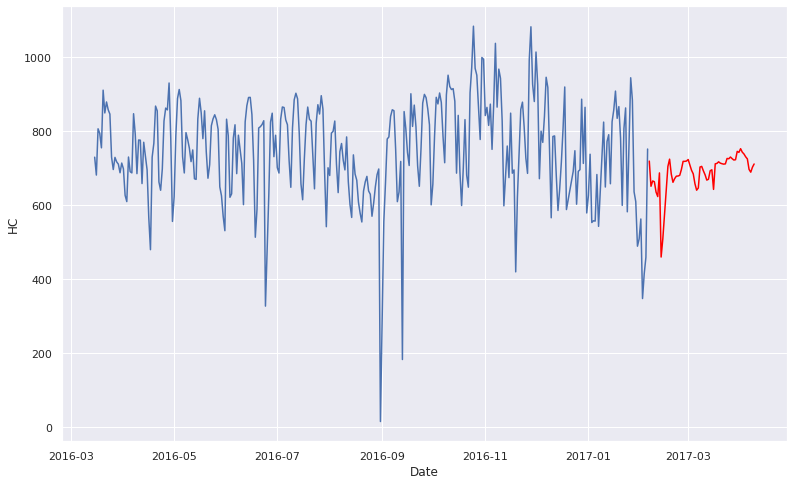

In [774]:
from datetime import datetime,timedelta
result,want=experiment_result(cdata,testdf,['CO','HC','NO2','O3'],parameter,['T','RH'])

In [772]:
exportdf=pd.DataFrame(result,columns=['Value'])


In [767]:
exportdf['id']=exportdf.index


In [768]:
pd.DataFrame({'id':exportdf.index,'Value':result}).to_csv('./result.csv',index=False)



In [734]:
pd.DataFrame(want).to_csv('get.csv')
